# **Lab: SVMs on Extended MNIST**

Digit and Non-Digit recognition wherein non-digits are assigned to 11th class

Importing required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Downloading the EMNIST Dataset

In [2]:
from tqdm import tqdm
import requests
import os
import zipfile

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

matlab_dir = 'matlab'
digits_fn =  os.path.join(matlab_dir,'emnist-digits.mat')
letters_fn = os.path.join(matlab_dir,'emnist-letters.mat')

# Check if files exists
if os.path.exists(matlab_dir):
    if os.path.exists(digits_fn) and os.path.exists(letters_fn):
        print('Files already downloaded')
        files_exists = True
else:
    files_exists = False
    
if not files_exists:
    # First download the zip file if needed
    src_url = "http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip"
    dst_fn = 'matlab.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

Files already downloaded


In [3]:
import scipy.io
def load_emnist(file_path='emnist-digits.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [4]:
Xtr_dig, Xts_dig, ytr_dig, yts_dig = load_emnist(digits_fn)

240000 training samples, 40000 test samples loaded


In [5]:
Xtr_let, Xts_let, ytr_let, yts_let = load_emnist(letters_fn)

124800 training samples, 20800 test samples loaded


In [6]:
ntr_dig = Xtr_dig.shape[0]
nts_dig = Xts_dig.shape[0]

ntr_let = Xtr_let.shape[0]
nts_let = Xts_let.shape[0]

Plotting the digits

In [7]:
def plt_entity(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq.T,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

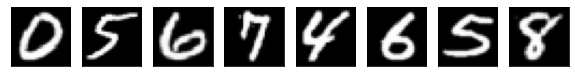

In [8]:
nplt = 8
Iperm = np.random.permutation(ntr_dig)

fig, ax = plt.subplots(1,nplt,figsize=(10,3))
for i in range(nplt):
    ind = Iperm[i]
    plt_entity(ax[i], Xtr_dig[ind,:])

Plotting the letters

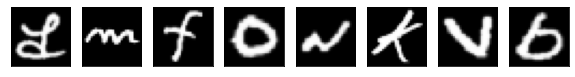

In [9]:
nplt = 8
Iperm = np.random.permutation(ntr_let)

fig, ax = plt.subplots(1,nplt,figsize=(10,3))
for i in range(nplt):
    ind = Iperm[i]
    plt_entity(ax[i], Xtr_let[ind,:])

**Creating a Non-Digit Class**

Removing letters similar to numbers

In [10]:
Xts_let.shape

(20800, 784)

In [11]:
remove_list = np.array([9,12,15])

temp1 = np.nonzero(ytr_let[:,None] == remove_list)[0]
Xtr_let_rem = np.delete(Xtr_let, temp1, axis=0)
ytr_let_rem = np.delete(ytr_let, temp1)

temp2 = np.nonzero(yts_let[:,None] == remove_list)[0]
Xts_let_rem = np.delete(Xts_let, temp2, axis=0)
yts_let_rem = np.delete(yts_let, temp2)

In [12]:
ntr_let_new = Xtr_let_rem.shape[0]
nts_let_new = Xts_let_rem.shape[0]

Creating train and test splits

In [13]:
ntr_dig2 = 5000
nts_dig2 = 5000
nts_let2 = 1000
ntr_let2 = 1000

Iperm_tr_dig = np.random.permutation(ntr_dig)
Iperm_ts_dig = np.random.permutation(nts_dig)
Iperm_tr_let = np.random.permutation(ntr_let_new)
Iperm_ts_let = np.random.permutation(nts_let_new)

In [14]:
Xtr1_dig = Xtr_dig[Iperm_tr_dig[:ntr_dig2],:]
ytr1_dig = ytr_dig[Iperm_tr_dig[:ntr_dig2]]
Xtr1_let = Xtr_let_rem[Iperm_tr_let[:ntr_let2],:]
ytr1_let = ytr_let_rem[Iperm_tr_let[:ntr_let2]]

Xts1_dig = Xts_dig[Iperm_ts_dig[:nts_dig2],:]
yts1_dig = yts_dig[Iperm_ts_dig[:nts_dig2]]
Xts1_let = Xts_let_rem[Iperm_ts_let[:nts_let2],:]
yts1_let = yts_let_rem[Iperm_ts_let[:nts_let2]]

Assigning class label = 10 for all letters

In [15]:
ytest = np.full((1000,), 10)

In [16]:
Xtr = np.vstack((Xtr1_dig, Xtr1_let))
Xts = np.vstack((Xts1_dig, Xts1_let))

In [17]:
ytr = np.hstack((ytr1_dig, ytest))
yts = np.hstack((yts1_dig, ytest))

In [18]:
Xtr1 = 2*(Xtr/255 - 0.5)
Xts1 = 2*(Xts/255 - 0.5)

**Running the SVM Classifier**

In [19]:
from sklearn import svm
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073)

In [20]:
svc.fit(Xtr1, ytr)

SVC(C=2.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
yhat_ts = svc.predict(Xts1)

In [22]:
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.912833


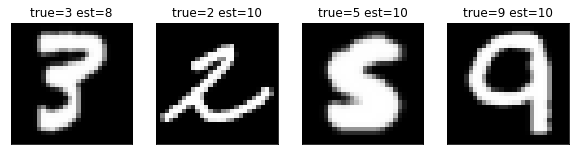

In [23]:
Ierr = np.where((yhat_ts != yts))[0]
nplt = 4
fig, ax = plt.subplots(1,nplt,figsize=(10, 4))
for i in range(nplt):             
    ind = Ierr[i]    
    plt_entity(ax[i], Xts1[ind,:])        
    title = 'true={0:d} est={1:d}'.format(yts[ind].astype(int), yhat_ts[ind].astype(int))
    ax[i].set_title(title)

[[0.928 0.    0.    0.    0.002 0.    0.002 0.002 0.    0.    0.032]
 [0.    0.98  0.    0.    0.    0.    0.002 0.004 0.002 0.    0.006]
 [0.004 0.    0.913 0.    0.    0.    0.    0.006 0.    0.    0.04 ]
 [0.    0.    0.01  0.929 0.    0.006 0.    0.004 0.01  0.004 0.018]
 [0.    0.    0.    0.002 0.891 0.    0.002 0.    0.    0.009 0.053]
 [0.002 0.    0.    0.01  0.002 0.904 0.004 0.    0.002 0.006 0.036]
 [0.    0.002 0.    0.    0.002 0.002 0.922 0.    0.002 0.    0.035]
 [0.    0.    0.004 0.    0.004 0.    0.    0.966 0.    0.009 0.009]
 [0.002 0.002 0.002 0.006 0.    0.002 0.    0.    0.887 0.004 0.046]
 [0.    0.002 0.    0.004 0.009 0.    0.    0.002 0.004 0.94  0.017]
 [0.017 0.01  0.041 0.014 0.033 0.063 0.042 0.008 0.027 0.047 0.849]]


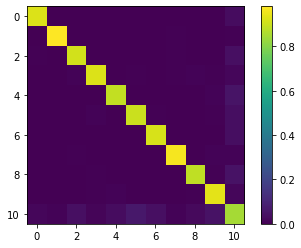

In [24]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat_ts)


Csum = np.sum(C,1)
C = C / Csum[None,:]


print(np.array_str(C, precision=3, suppress_small=True))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [26]:
dig_mis = 0
let_mis = 0
for i in range(len(yts)):
  if yts[i] != 10 and yhat_ts[i] == 10:
    dig_mis = dig_mis + 1
  if yts[i] == 10 and yhat_ts[i] != 10:
    let_mis = let_mis + 1

digits = Xts1_dig.shape[0]
letters = Xts1_let.shape[0]
print("Fraction of digits mislabeled as letters = ", dig_mis/digits)
print("Fraction of letters mislabeled as digits = ", let_mis/letters)

Fraction of digits mislabeled as letters =  0.0584
Fraction of letters mislabeled as digits =  0.151


**Selecting gamma and C via Cross-Validation (Using For-Loops)**

In [27]:
C_test = [0.1,1,10]
gam_test = [0.001,0.01,0.1]

nC = len(C_test)
ngam = len(gam_test)
acc = np.zeros((nC,ngam))

for i in range(3):
  for j in range(3):
    svc = svm.SVC(probability=False,  kernel="rbf", C=C_test[i], gamma=gam_test[j])
    svc.fit(Xtr1, ytr)
    yhat_ts = svc.predict(Xts1)
    acc[i, j] = np.mean(yhat_ts == yts)


Printing the accuracy matrix

In [28]:
acc

array([[0.79316667, 0.59533333, 0.16666667],
       [0.87333333, 0.89183333, 0.21533333],
       [0.90283333, 0.89516667, 0.21733333]])

In [29]:
indices = np.where(acc == acc.max())
i = indices[0][0]
j = indices[1][0]
Cmax = C_test[i]
Gammax = gam_test[j]

print("The maximum accuracy is = {}\nCorresponding C is = {}\nCorresponding gamma is = {}".format(acc.max(), Cmax, Gammax))

The maximum accuracy is = 0.9028333333333334
Corresponding C is = 10
Corresponding gamma is = 0.001
